In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from data.download import RawData

### Relationship between two indices: Vix and S&P 500

VIX (CBOE Volatility Index) is a widely-used measure of market volatility and investor sentiment. It is often referred to as the "fear index" as it reflects the expected volatility of the S&P 500 index over the next 30 days.

The S&P 500 is a stock market index that represents the performance of 500 large-cap companies listed on stock exchanges in the United States. It is considered a benchmark for the overall health and performance of the U.S. stock market. The VIX index and the S&P 500 are inversely related, meaning that they tend to move in opposite directions. When the VIX index is high, it suggests that there is increased uncertainty and fear in the market, which often leads to a decrease in the value of the S&P 500. Conversely, when the VIX index is low, it indicates lower expected volatility and higher investor confidence, which may lead to an increase in the value of the S&P 500.

Traders, investors, and financial analysts closely monitor the relationship between the VIX index and the S&P 500 to gauge market sentiment, assess risk levels, and make informed decisions in their investment strategies.

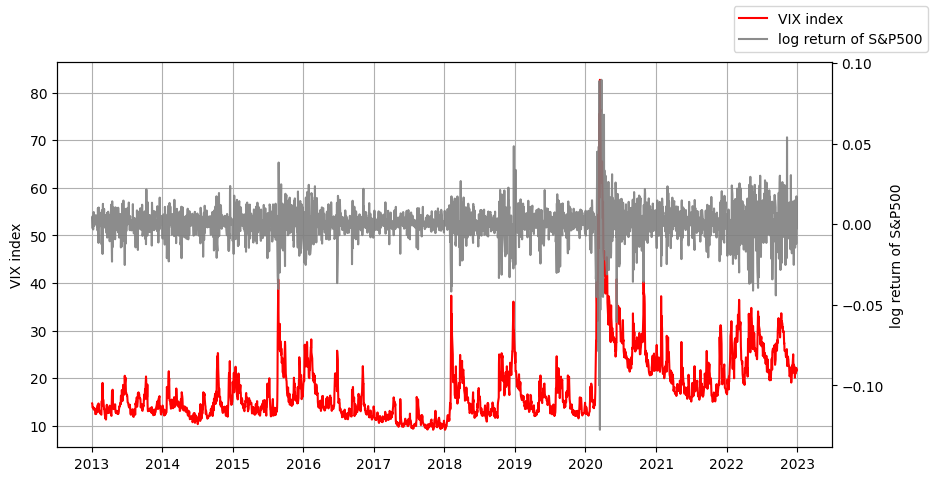

In [2]:
vix = RawData.get("vix")
snp500 = RawData.get("snp500")
n = -3000

fig, ax1 = plt.subplots(figsize=(10, 5))
ax1.plot(vix["Close"][n:], label="VIX index", color="red")
ax1.set_ylabel("VIX index")
ax1.grid()

ax2 = ax1.twinx()
snp500["Logreturn"] = (np.log(snp500['Close']).diff(1))
ax2.plot(snp500["Logreturn"][n:], label="log return of S&P500", color="grey", alpha=0.9)
ax2.set_ylabel("log return of S&P500")

fig.legend()
plt.show()

fig.savefig("./assets/vix_snp500.png", dpi=300, bbox_inches="tight")

### ARIMA Features

ARIMA (AutoRegressive Integrated Moving Average) features are additional input features used in the prediction model to capture the time series patterns in the data.
The absolute values of the S&P 500 are used as ARIMA features because they have shown higher correlations with the VIX index.
By including the absolute values of the S&P 500 as ARIMA features, the model can potentially capture the magnitude of changes in the S&P 500, which may be relevant to predicting the VIX index.

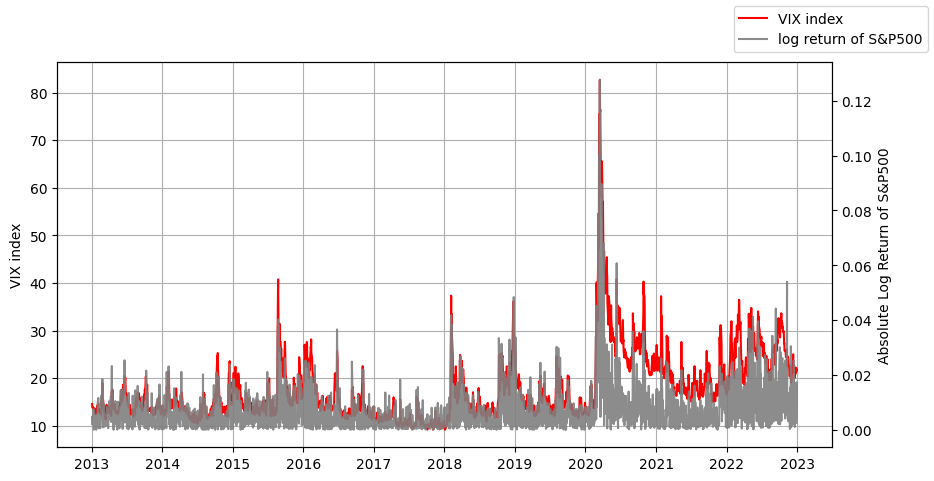

In [3]:
abs_snp = np.abs(snp500['Logreturn'])[1:]
snp = snp500['Logreturn'][1:]
vix = vix['Close'][1:]

fig, ax1 = plt.subplots(figsize=(10, 5))
ax1.plot(vix, label="VIX index", color="red")
ax1.set_ylabel("VIX index")
ax1.grid()

ax2 = ax1.twinx()
ax2.plot(abs_snp, label="log return of S&P500", color="grey", alpha=0.9)
ax2.set_ylabel("Absolute Log Return of S&P500")

fig.legend()
plt.show()

fig.savefig("./assets/vix_abs_snp500.png", dpi=300, bbox_inches="tight")

In [4]:

df = pd.DataFrame({
    'vix': vix,
    'snp': snp,
    'abs_snp': abs_snp})

df.corr()

,vix,snp,abs_snp
vix,1.000000,-0.165672,0.637135
snp,-0.165672,1.000000,-0.124347
abs_snp,0.637135,-0.124347,1.000000


/Users/jiyoonkim/opt/anaconda3/envs/ivp_env/lib/python3.9/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


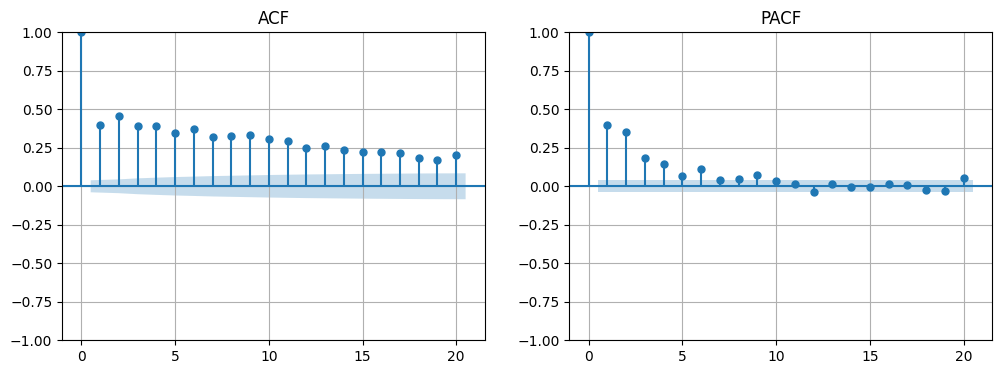

In [5]:
import statsmodels.graphics.tsaplots as sgt 

fig, axes = plt.subplots(1,2,figsize=(12,4))
sgt.plot_acf(np.abs(snp500['Logreturn'])[1:], lags = 20, ax=axes[0])
axes[0].set_title("ACF")
axes[0].grid()

sgt.plot_pacf(np.abs(snp500['Logreturn'])[1:], lags = 20, ax=axes[1])
axes[1].set_title("PACF")
axes[1].grid()

plt.show()

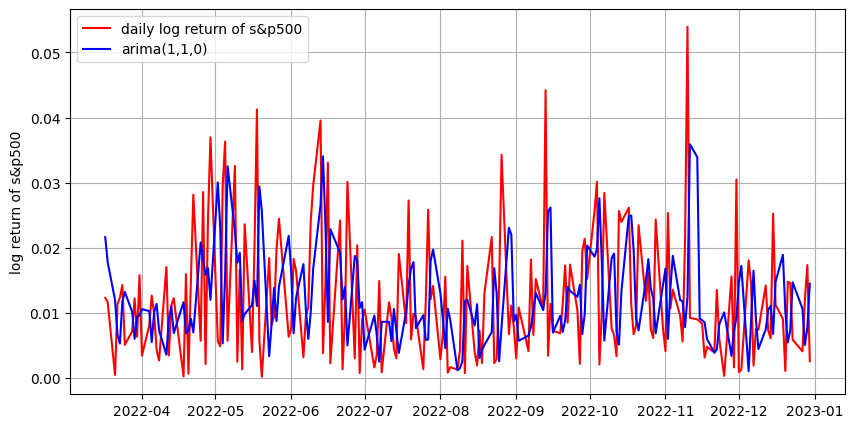

In [6]:
# arima plot
from data.download import RawData

snp500 = RawData.get("snp500")
n = -200

fig, ax1 = plt.subplots(figsize=(10, 5))
snp500["Logreturn"] = (np.log(snp500['Close']).diff(1))
ax1.plot(np.abs(snp500["Logreturn"][n:]), label="daily log return of s&p500", color="red")

arima = pd.read_csv(f"./data/features/vix_snp500_arima_test.csv", index_col=None)
arima.index = snp500.index[-len(arima):]
ax1.plot(arima["predicted_mean"][n:], label="arima(1,1,0)", color="blue")

ax1.set_ylabel("log return of s&p500")
ax1.grid()
ax1.legend()

plt.show()

# Experiments

Several models, including MLP (Multi-Layer Perceptron), LSTM (Long Short-Term Memory), and WaveNet, were tested with the ARIMA features to predict the VIX index.

The WaveNet model, known for its ability to capture long-term dependencies and complex patterns in time series data, showed promising performance in predicting the VIX index with the added ARIMA features. The results suggest that the WaveNet model may be well-suited for capturing the dynamics of the VIX index and the impact of ARIMA features derived from the absolute values of the S&P 500.


## Predictions

#### 1. mlp

/var/folders/w4/c3vgfb7s6pd2__6kdr25mbvc0000gn/T/ipykernel_97356/2195517473.py:24: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


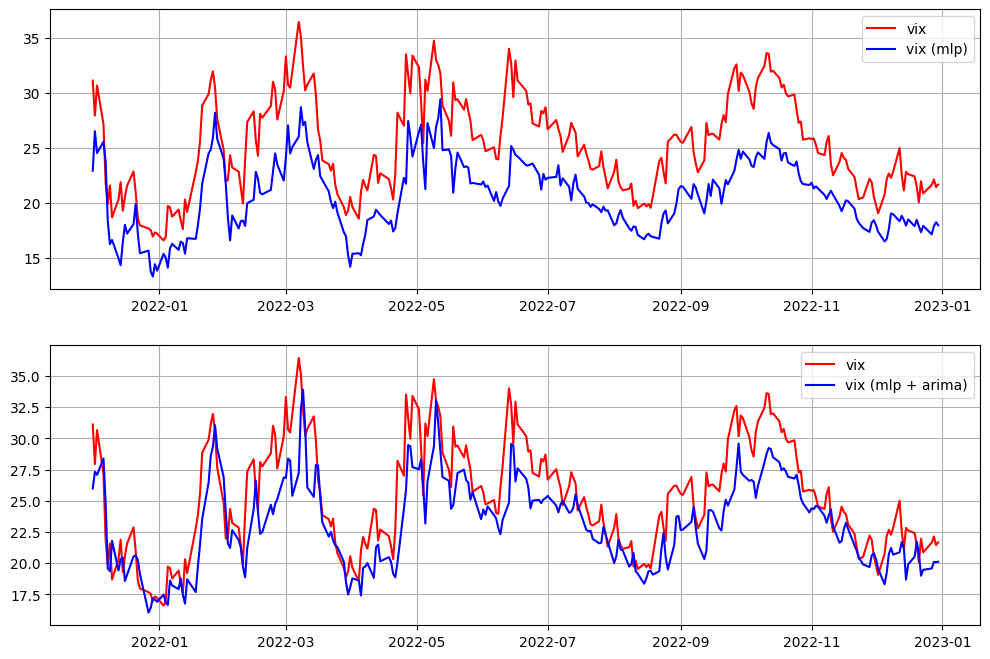

In [7]:
vix = RawData.get("vix")
vix = vix["Close"]
n1 = "2021-12-01"
n2 = "2022-12-30"

mlp = pd.read_csv(f"./results/predictions/mlp.csv", index_col=None, header=None)
mlp.index = vix.index[-len(mlp):]

mlp2 = pd.read_csv(f"./results/predictions/mlp_arima.csv", index_col=None, header=None)
mlp2.index = vix.index[-len(mlp2):]

fig, axes = plt.subplots(2,1, figsize=(12, 8))

axes[0].plot(vix[n1:n2], label="vix", color="red")
axes[0].plot(mlp[n1:n2], label=f"vix (mlp)", color="blue")
axes[0].legend(loc="upper right")
axes[0].grid()

axes[1].plot(vix[n1:n2], label="vix", color="red")
axes[1].plot(mlp2[n1:n2], label=f"vix (mlp + arima)", color="blue")
axes[1].legend(loc="upper right")
axes[1].grid()

fig.show()

fig.savefig("./assets/mlp.png", dpi=300, bbox_inches="tight")

#### 2. lstm

/var/folders/w4/c3vgfb7s6pd2__6kdr25mbvc0000gn/T/ipykernel_97356/1701189939.py:24: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


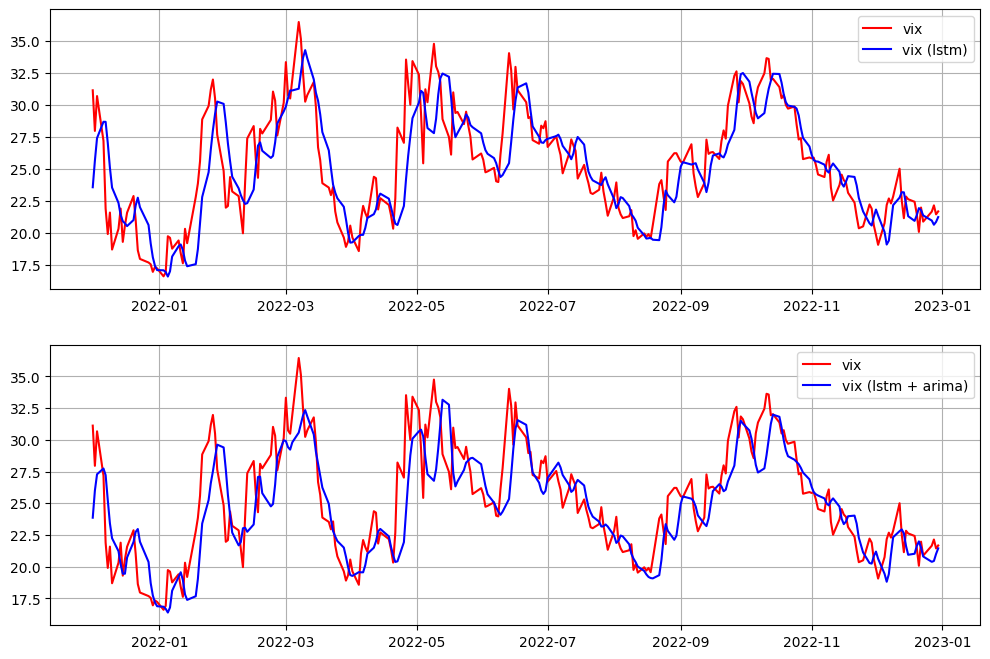

In [8]:
vix = RawData.get("vix")
vix = vix["Close"]
n1 = "2021-12-01"
n2 = "2022-12-30"

lstm = pd.read_csv(f"./results/predictions/lstm.csv", index_col=None, header=None)
lstm.index = vix.index[-len(lstm):]

lstm2 = pd.read_csv(f"./results/predictions/lstm_arima.csv", index_col=None, header=None)
lstm2.index = vix.index[-len(lstm2):]

fig, axes = plt.subplots(2,1, figsize=(12, 8))

axes[0].plot(vix[n1:n2], label="vix", color="red")
axes[0].plot(lstm[n1:n2], label=f"vix (lstm)", color="blue")
axes[0].legend(loc="upper right")
axes[0].grid()

axes[1].plot(vix[n1:n2], label="vix", color="red")
axes[1].plot(lstm2[n1:n2], label=f"vix (lstm + arima)", color="blue")
axes[1].legend(loc="upper right")
axes[1].grid()

fig.show()

fig.savefig("./assets/lstm.png", dpi=300, bbox_inches="tight")

#### 3. WaveNet

/var/folders/w4/c3vgfb7s6pd2__6kdr25mbvc0000gn/T/ipykernel_97356/1683249527.py:25: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


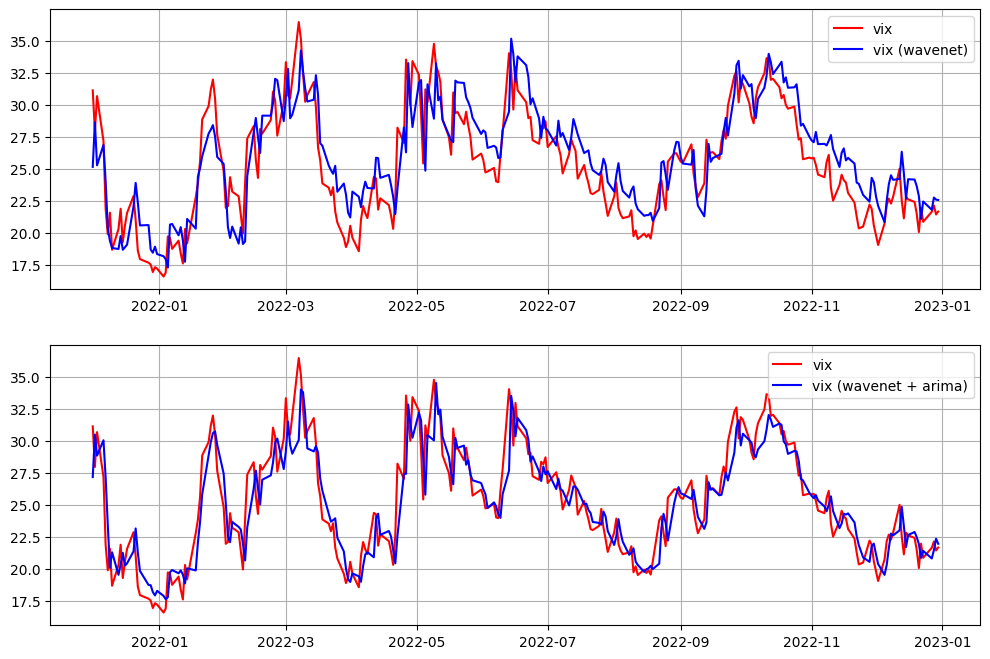

In [9]:
vix = RawData.get("vix")
vix = vix["Close"]
n1 = "2021-12-01"
n2 = "2022-12-30"

wavenet = pd.read_csv(f"./results/predictions/wavenet.csv", index_col=None, header=None)
wavenet.index = vix.index[-len(wavenet):]

wavenet2 = pd.read_csv(f"./results/predictions/wavenet_arima.csv", index_col=None, header=None)
wavenet2.index = vix.index[-len(wavenet2):]


fig, axes = plt.subplots(2,1, figsize=(12, 8))

axes[0].plot(vix[n1:n2], label="vix", color="red")
axes[0].plot(wavenet[n1:n2], label=f"vix (wavenet)", color="blue")
axes[0].legend(loc="upper right")
axes[0].grid()

axes[1].plot(vix[n1:n2], label="vix", color="red")
axes[1].plot(wavenet2[n1:n2], label=f"vix (wavenet + arima)", color="blue")
axes[1].legend(loc="upper right")
axes[1].grid()

fig.show()

fig.savefig("./assets/wavenet.png", dpi=300, bbox_inches="tight")

## Errors

In [10]:
# errors
import os
import json

errors = []
indices = []
for name in os.listdir('./results/errors/'):    
    with open('./results/errors/' + name) as f:
        errors.append(json.load(f))
        indices.append(name.replace('.json', ''))

errors = pd.DataFrame(errors, index=indices).sort_values(by='mse', ascending=False)
errors

,mse,mae,rmse,mape
mlp,18.888565,3.733225,4.107412,0.157731
mlp_arima,6.777174,1.920302,2.379199,0.079372
lstm,5.962223,1.760764,2.216405,0.076254
lstm_arima,5.886991,1.720101,2.211673,0.073815
wavenet,4.668662,1.678188,2.046593,0.073690
wavenet_arima,3.437923,1.426503,1.743127,0.064706


#### Diebold-Mariano (DM) test

The Diebold-Mariano (DM) test was introduced by Francis X. Diebold and Robert S. Mariano in their 1995 paper titled "Comparing Predictive Accuracy". The test is widely used in the field of time series forecasting to assess the relative performance of different prediction models and guide model selection.

The DM test results reveal a statistically significant difference in forecast accuracy between models with and without ARIMA features. Also the inclusion of ARIMA features in the WaveNet model leads to improved forecast accuracy compared to other models.

/Users/jiyoonkim/opt/anaconda3/envs/ivp_env/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


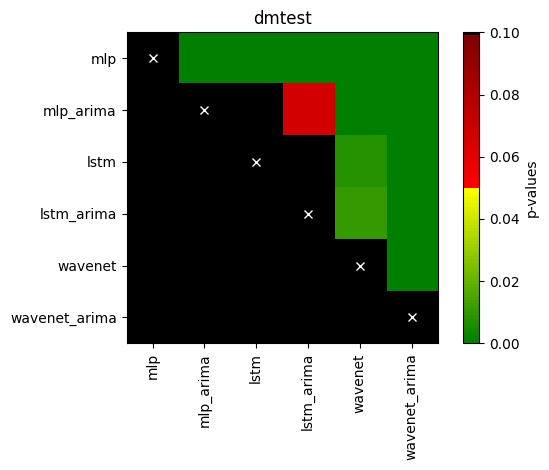

In [11]:
from utils import dm_test

vix = RawData.get("vix")
vix = vix["Close"][wavenet.index]

predictions = [mlp, mlp2, lstm, lstm2, wavenet, wavenet2]
predictions = pd.concat(predictions, axis=1)
predictions.columns = ['mlp', 'mlp_arima', 'lstm', 'lstm_arima', 'wavenet', 'wavenet_arima']

dm_test(vix, predictions, savefig=True)